In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_absolute_error
import time
import pickle
from scipy.stats import norm
from mapie.regression import MapieQuantileRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
import os
from pathlib import Path
PROJ_ROOT = Path(os.getcwd()).parent # add project root file to the python paths
sys.path.append(str(PROJ_ROOT))

from src.simulations.simulate_data import DataGenerator

## Load predictions for three values of $\kappa$

In [2]:
df_4strikes = pd.read_csv(PROJ_ROOT / 'models' / 'simulation_1' / 'sample_5' / 'cp_predictions.csv')

In [3]:
df_4strikes

,lb,pp,ub,valid,pp_valid
0,0.093132,0.094183,0.095347,True,True
1,0.123048,0.125382,0.125391,True,True
2,0.141014,0.141385,0.144831,True,True
3,0.007715,0.010450,0.031692,True,True
4,0.104952,0.107351,0.106881,True,False
...,...,...,...,...,...
499995,-0.000178,0.000855,0.001753,True,True
499996,0.116887,0.118084,0.120051,True,True
499997,0.043807,0.047322,0.048718,True,True
499998,0.005580,0.007659,0.007892,True,True


In [4]:
df_20strikes = pd.read_csv(PROJ_ROOT / 'run_sim3' / 'models' / 'simulation' / 'sample_5' / 'cp_predictions.csv')

In [5]:
df_20strikes

,lb,pp,ub,valid,pp_valid
0,0.337189,0.339421,0.345461,True,True
1,0.458154,0.461975,0.463008,True,True
2,0.477099,0.486394,0.491220,True,True
3,0.419768,0.420083,0.421213,True,True
4,0.449393,0.451757,0.456007,True,True
...,...,...,...,...,...
499995,0.250515,0.247706,0.252553,True,False
499996,0.242993,0.241915,0.247209,True,False
499997,0.272896,0.271299,0.276682,True,False
499998,0.239292,0.238636,0.242699,True,False


In [6]:
df_1strikes = pd.read_csv(PROJ_ROOT / 'run_sim2' / 'models' / 'sample_5' / 'cp_predictions.csv')

In [7]:
df_1strikes

,lb,pp,ub,valid,pp_valid
0,0.538240,0.596150,0.598420,True,True
1,0.440622,0.444263,0.442623,True,False
2,0.254806,0.256441,0.257193,True,True
3,0.322668,0.324926,0.326148,True,True
4,0.425294,0.428753,0.436087,True,True
...,...,...,...,...,...
499995,0.527620,0.593921,0.600030,True,True
499996,0.369667,0.370766,0.372925,True,True
499997,0.515757,0.544627,0.551216,True,True
499998,0.081727,0.084573,0.085048,True,True


# Inspect the results

In [8]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [9]:
dataset = df_4strikes
strikes_per_S = 4

In [10]:
from scipy.stats import norm
from src.utils.common import d1, d2, black_scholes_price

total_sample_size = 500_000
# strikes_per_S = 4
param_bounds = {
    'S': [500, 1000],
    'sigma': [0.1, 1],
    'tau': [14/252, 2],
    'r': [0.1/100, 5/100],
}

size_per_S = int(total_sample_size/strikes_per_S)

# generate data from uniform distribution for each parameter
np.random.seed(98765)
data = {}
for param in param_bounds.keys():
    data[param] = np.repeat( # repeat the same sampled value strikes_per_S times
        np.random.uniform(
            param_bounds[param][0], # lower bound
            param_bounds[param][1], # upper bound 
            size_per_S), 
        strikes_per_S)

# generate 'strikes_per_S' number of strikes from normal with mean S and std 0.1*S, for each S
z = np.random.normal(
        1, # mean
        # variance of 0.1 => std=sqrt(0.1)=0.316
        # ~300 strikes will be negative
        # the author probably used 0.1 as a variance, not std.
        # With std=0.1, the number of negative strikes will be ~0
        0.1, 
        total_sample_size)

data['K'] = data['S']/z

data = pd.DataFrame(data)
data['C'] = black_scholes_price(data['S'], data['K'], data['r'], data['sigma'], data['tau'], option_type="call")
# Assume homogeneity
data['S'] = data['S']/data['K']
data['C'] = data['C']/data['K']
data.drop('K', axis=1, inplace=True)
test_data = data

X_test, y_test = test_data.drop('C', axis=1), test_data['C']

In [11]:
res = pd.concat([pd.DataFrame({'y_true': y_test}), dataset.loc[:,['lb', 'ub']], X_test], axis=1)

In [12]:
res

,y_true,lb,ub,S,sigma,tau,r
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479
...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646


In [13]:
res.describe()

,y_true,lb,ub,S,sigma,tau,r
count,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,2.222771e-01,0.219111,0.225097,1.000071,0.549544,1.028235,0.025527
std,1.320193e-01,0.129199,0.132333,0.100105,0.259155,0.561772,0.014156
min,5.669809e-46,-0.002567,-0.001429,0.467998,0.100014,0.055599,0.001000
25%,1.184811e-01,0.116713,0.120739,0.932386,0.324878,0.540491,0.013284
50%,2.068531e-01,0.205034,0.209308,1.000019,0.549548,1.028868,0.025556
75%,3.128191e-01,0.310515,0.315796,1.067621,0.773426,1.517701,0.037827
max,8.302856e-01,0.568035,0.803136,1.442970,0.999999,1.999992,0.050000


In [14]:
100* (res.lb < 0.0).sum() / len(res) # in percentage

0.3924

In [15]:
100*(res.ub < 0.0).sum() / len(res)

0.0116

In [16]:
res.loc[:, 'in_interval'] = (res.loc[:, 'y_true'] >= res.loc[:, 'lb']) & (res.loc[:, 'y_true'] <= res.loc[:, 'ub'])

In [17]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415,False
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415,True
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415,True
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415,True
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479,False
...,...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452,True
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646,True
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646,True
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646,True


In [18]:
res.in_interval.mean()

0.883978

In [19]:
res.loc[:, 'ill'] = (res.loc[:, 'ub'] <= res.loc[:, 'lb'])

In [20]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415,False,False
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415,True,False
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415,True,False
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415,True,False
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479,False,False
...,...,...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452,True,False
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646,True,False
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646,True,False
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646,True,False


In [21]:
100*res.ill.sum() / len(res)

0.3642

In [22]:
res = res.loc[~res.ill, :]

In [23]:
res.shape

(498179, 9)

In [24]:
pd.options.mode.copy_on_write = True

In [25]:
res.loc[:, 'abs_width'] = res.loc[:, 'ub'] - res.loc[:, 'lb']

In [26]:
res.loc[:, 'rel_width'] = 100 * res.loc[:, 'abs_width'] / res.loc[:, 'y_true']

In [27]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415,False,False,0.002215,2.384310
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415,True,False,0.002343,1.895369
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415,True,False,0.003816,2.694945
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415,True,False,0.023977,198.188116
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479,False,False,0.001929,1.852943
...,...,...,...,...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452,True,False,0.001931,320.835263
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646,True,False,0.003164,2.651393
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646,True,False,0.004911,10.350920
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646,True,False,0.002312,33.561465


In [28]:
# 

In [29]:
res.describe()

,y_true,lb,ub,S,sigma,tau,r,abs_width,rel_width
count,4.981790e+05,498179.000000,498179.000000,498179.000000,498179.000000,498179.000000,498179.000000,4.981790e+05,4.981790e+05
mean,2.222075e-01,0.219032,0.225041,1.000010,0.549485,1.028135,0.025525,6.009584e-03,2.978778e+38
std,1.319775e-01,0.129148,0.132298,0.100049,0.259027,0.561671,0.014153,8.963241e-03,2.102475e+41
min,5.669809e-46,-0.002567,-0.001009,0.467998,0.100014,0.055599,0.001000,6.817916e-08,3.077715e-05
25%,1.184893e-01,0.116716,0.120762,0.932412,0.325021,0.540573,0.013289,2.968888e-03,1.366927e+00
50%,2.067746e-01,0.204958,0.209221,0.999944,0.549366,1.028757,0.025553,4.089452e-03,2.123754e+00
75%,3.125832e-01,0.310254,0.315568,1.067441,0.773009,1.517371,0.037819,5.697705e-03,3.801016e+00
max,8.302856e-01,0.568035,0.803136,1.442970,0.999999,1.999992,0.050000,2.444050e-01,1.483965e+44


### Frequency of widths

In [30]:
(res.loc[:, 'rel_width'] < 100.0).sum() / len(res)

0.9884338761770368

In [31]:
# windsorize the relative width to 100
res_windsorized = res.copy()

res_windsorized.loc[res.loc[:, 'rel_width'] > 100.0, 'rel_width'] = 100.0


In [32]:
res_windsorized

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415,False,False,0.002215,2.384310
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415,True,False,0.002343,1.895369
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415,True,False,0.003816,2.694945
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415,True,False,0.023977,100.000000
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479,False,False,0.001929,1.852943
...,...,...,...,...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452,True,False,0.001931,100.000000
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646,True,False,0.003164,2.651393
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646,True,False,0.004911,10.350920
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646,True,False,0.002312,33.561465


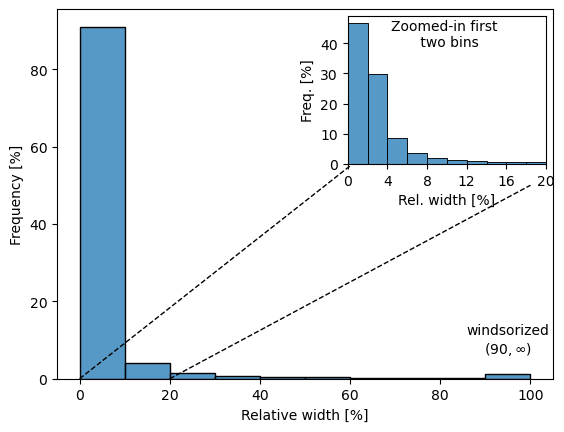

In [33]:
# plot frequecy of relative widths 
sns.histplot(res_windsorized.loc[:, 'rel_width'], bins=10, stat='percent')
plt.xlabel("Relative width [%]")
plt.ylabel("Frequency [%]")

plt.text(95, 10, "windsorized\n$(90,\infty)$", verticalalignment='center', horizontalalignment='center', fontsize=10)

# add dashed line from (0, 0) to (100, 100)
plt.plot([0, 60], [0, 55], 'k--', lw=1)
plt.plot([20, 100], [0, 50], 'k--', lw=1)


# add sublot of the same kind with the zoomed in version of the plot for x in [0, 20]
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='upper right')

sns.histplot(res_windsorized.loc[:, 'rel_width'], bins=50, stat='percent', ax=ax_inset)
ax_inset.set_xlim(0, 20)  # Set x-axis limits to [0, 20] for the inset
ax_inset.set_ylabel('Freq. [%]')  # Hide y-axis label on the inset plot
ax_inset.set_xlabel("Rel. width [%]")  # Hide x-axis label on the inset plot
# add title inside the inset plot
ax_inset.text(0.5, 0.88, 'Zoomed-in first \n two bins', horizontalalignment='center', verticalalignment='center', transform=ax_inset.transAxes)
ax_inset.set_xticks(np.arange(0, 21, 4))



# add text to the last bin "windsorized"
plt.savefig(str(PROJ_ROOT) + f"/reports/figures/simulated_data/sim_kappa{strikes_per_S}_relative_widths.png",
            dpi=400)
plt.show()


### Median width over true option price

In [34]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
0,0.092910,0.093132,0.095347,1.012257,0.701505,0.090440,0.048415,False,False,0.002215,2.384310
1,0.123634,0.123048,0.125391,1.062039,0.701505,0.090440,0.048415,True,False,0.002343,1.895369
2,0.141616,0.141014,0.144831,1.088454,0.701505,0.090440,0.048415,True,False,0.003816,2.694945
3,0.012098,0.007715,0.031692,0.785035,0.701505,0.090440,0.048415,True,False,0.023977,198.188116
4,0.104117,0.104952,0.106881,0.903044,0.902738,0.183897,0.026479,False,False,0.001929,1.852943
...,...,...,...,...,...,...,...,...,...,...,...
499995,0.000602,-0.000178,0.001753,0.855215,0.153851,0.254386,0.003452,True,False,0.001931,320.835263
499996,0.119333,0.116887,0.120051,1.067295,0.403889,0.220760,0.022646,True,False,0.003164,2.651393
499997,0.047441,0.043807,0.048718,0.936534,0.403889,0.220760,0.022646,True,False,0.004911,10.350920
499998,0.006890,0.005580,0.007892,0.771253,0.403889,0.220760,0.022646,True,False,0.002312,33.561465


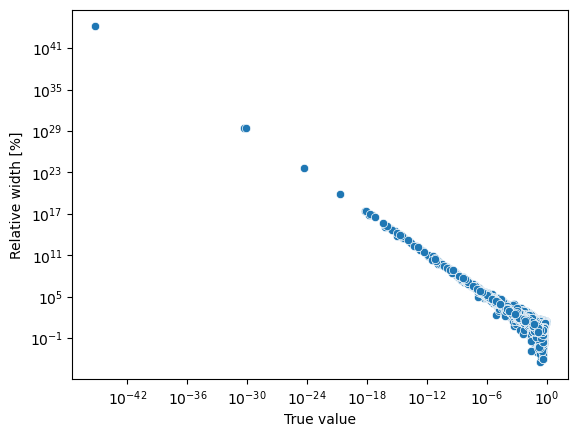

In [35]:
# plot the relative width against the true value
sns.scatterplot(data=res, x='y_true', y='rel_width')
plt.xlabel("True value")
plt.ylabel("Relative width [%]")
plt.xscale('log')
plt.yscale('log')


In [36]:
# bin the data by the true value
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=10)





In [37]:
# check frequency of the bins
res.loc[:, 'y_true_bin'].value_counts()

y_true_bin
(0.083, 0.166]       114252
(0.166, 0.249]       111854
(0.249, 0.332]        88005
(-0.00083, 0.083]     77750
(0.332, 0.415]        60227
(0.415, 0.498]        32377
(0.498, 0.581]        11313
(0.581, 0.664]         2178
(0.664, 0.747]          210
(0.747, 0.83]            13
Name: count, dtype: int64

In [38]:
# make binning along the true value with log scale
y_true_bins_seq = np.logspace(np.log10(res.loc[:, 'y_true'].min()), np.log10(res.loc[:, 'y_true'].max()), num=11)
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=y_true_bins_seq, include_lowest=True)

In [39]:
res.loc[:, 'y_true_bin'].value_counts()

y_true_bin
(2.53e-05, 0.83]                                   497545
(7.69e-10, 2.53e-05]                                  551
(2.34e-14, 7.69e-10]                                   54
(7.13e-19, 2.34e-14]                                   23
(2.0100000000000002e-32, 6.600000000000001e-28]         2
(2.1700000000000004e-23, 7.13e-19]                      2
(-0.001, 1.8600000000000002e-41]                        1
(6.600000000000001e-28, 2.1700000000000004e-23]         1
(1.8600000000000002e-41, 6.120000000000002e-37]         0
(6.120000000000002e-37, 2.0100000000000002e-32]         0
Name: count, dtype: int64

In [40]:
# make binning along the true value with log scale
y_true_bins_seq = np.logspace(np.log10(0.00022), np.log10(res.loc[:, 'y_true'].max()), num=11)


y_true_bins_seq

array([2.20000000e-04, 5.01306302e-04, 1.14230913e-03, 2.60293984e-03,
       5.93122794e-03, 1.35152816e-02, 3.07967992e-02, 7.01755888e-02,
       1.59906659e-01, 3.64373708e-01, 8.30285619e-01])

In [41]:
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=y_true_bins_seq, include_lowest=True)

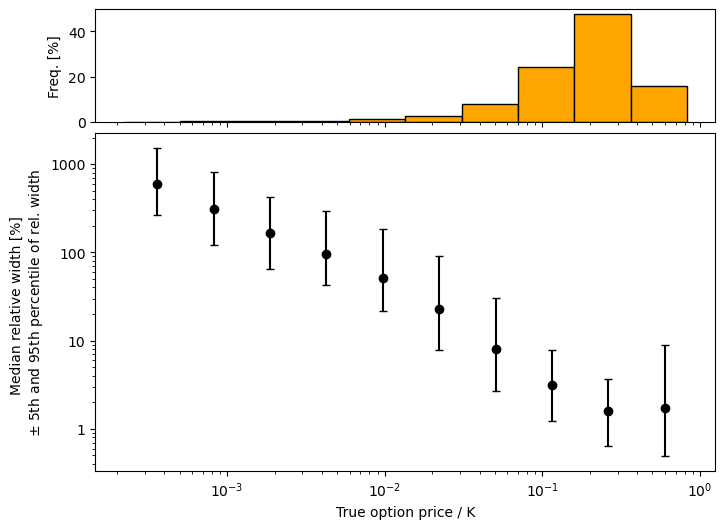

In [42]:
from matplotlib.ticker import LogFormatter


# Create the main figure and axes
fig, (ax_top, ax_main) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, sharex=True, figsize=(8, 6))
fig.subplots_adjust(hspace=0.05)  # Adjust space between subplots


# for each bin in y_true_bin, calculate the median relative width and plot it against the bin's center
bin_centers = res.groupby('y_true_bin').apply(lambda x: (x.loc[:, 'y_true'].max()+x.loc[:, 'y_true'].min())/2).values
bin_median_rel_width = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].median()).values

# add for each bin center its 5th and 95th percentile
bin_5th = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.05)).values
bin_95th = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.95)).values

# plt.plot(bin_centers, bin_median_rel_width, marker='o')
ax_main.errorbar(bin_centers, bin_median_rel_width, 
             yerr=[bin_median_rel_width-bin_5th, bin_95th-bin_median_rel_width], 
             color = 'black',
             capsize=3,
             fmt='o')

ax_main.set_yscale('log')  # Set log scale for the x-axis

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel("True option price / K")
#plt.ylabel("Median relative width \n$\pm$ 5th and 95th percentile of rel. width")
ax_main.set_xscale('log')  # Set log scale for the x-axis
ax_main.set_xlabel("True option price / K")
ax_main.set_ylabel("Median relative width [%] \n$\pm$ 5th and 95th percentile of rel. width")

# Customize y-axis to display plain numbers instead of scientific notation
ax_main.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.5)))
ax_main.yaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))

bin_counts = res.loc[:, 'y_true_bin'].value_counts().sort_index().values
bin_counts_rel = 100*bin_counts / bin_counts.sum()

# Plot the counts of each bin in the top subplot
ax_top.bar(bin_centers, bin_counts_rel, width=np.diff(y_true_bins_seq), color='orange', edgecolor='black', align='center')

ax_top.set_ylabel('Freq. [%]')
#ax_top.set_title('Counts in Each Bin')

plt.savefig(str(PROJ_ROOT) + f"/reports/figures/simulated_data/sim_kappa{strikes_per_S}_rel_widths_to_opt_price.png",
            dpi=400)
plt.show()



## Median width over features

In [43]:
# change ir to percentage
res.loc[:, 'r'] = 100 * res.loc[:, 'r']

In [44]:
labels_list = {'S': 'S/K', 
               'sigma': r'$\sigma$', 
               'tau': r'$\tau$ [years]', 
               'r': 'r [%]'}

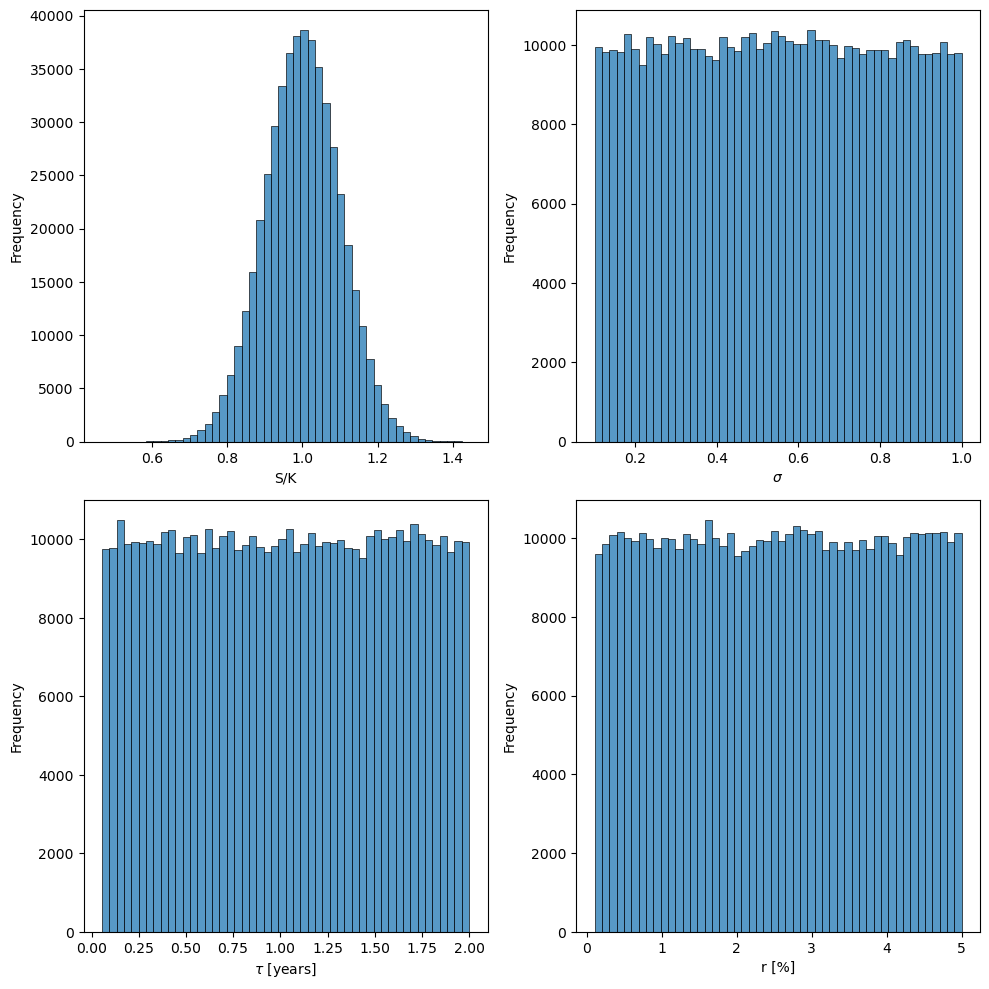

In [45]:
# plot dist of features ['S', 'sigma', 'tau', 'r']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, feature in enumerate(['S', 'sigma', 'tau', 'r']):
    sns.histplot(res.loc[:, feature], ax=axes[i//2, i%2], bins=50)
    axes[i//2, i%2].set_xlabel(labels_list[feature])
    axes[i//2, i%2].set_ylabel('Frequency')

# tight
plt.tight_layout()


In [135]:
# bin the data by S
res.loc[:, 'S_bin'] = pd.qcut(res.loc[:, 'S'], q=10)

# bin the data by sigma
res.loc[:, 'sigma_bin'] = pd.qcut(res.loc[:, 'sigma'], q=10)

# bin the data by tau
res.loc[:, 'tau_bin'] = pd.qcut(res.loc[:, 'tau'], q=10)

# bin the data by r
res.loc[:, 'r_bin'] = pd.qcut(res.loc[:, 'r'], q=10)


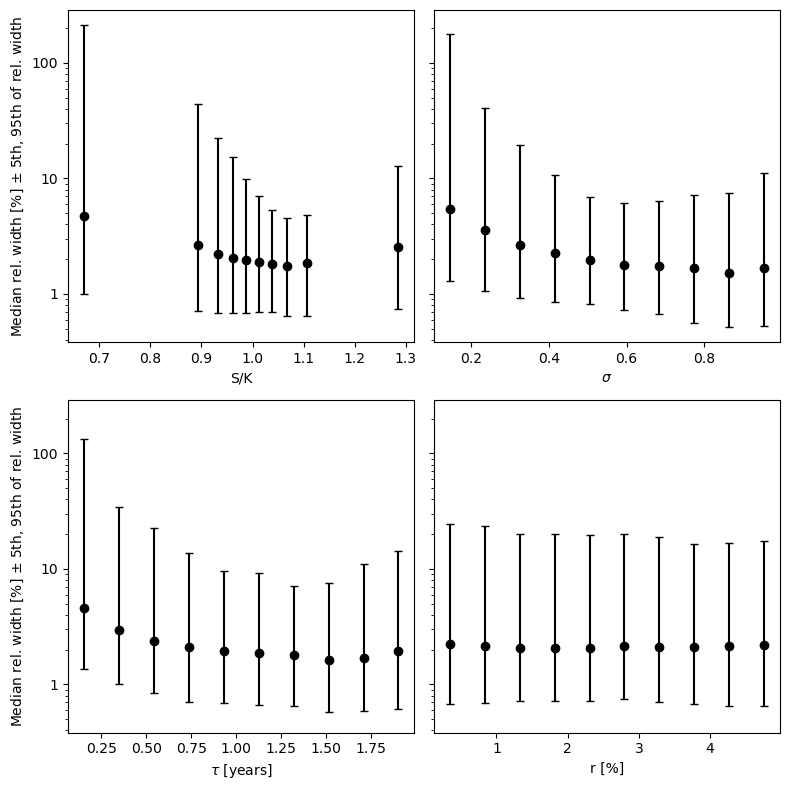

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)


for i, feature in enumerate(['S', 'sigma', 'tau', 'r']):
    bin_centers = res.groupby(feature+'_bin').apply(lambda x: (x.loc[:, feature].max()+x.loc[:, feature].min())/2).values
    bin_median_rel_width = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].median()).values
    #bin_widths = res.groupby(feature+'_bin').apply(lambda x: (x.loc[:, feature].max()-x.loc[:, feature].min()))).values

    # add for each bin center its 5th and 95th percentile
    bin_5th = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.05)).values
    bin_95th = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.95)).values
    
    #sns.histplot(res.loc[:, feature], ax=axes[i//2, i%2], bins=50)
    axes[i//2, i%2].errorbar(bin_centers, bin_median_rel_width, 
             yerr=[bin_median_rel_width-bin_5th, bin_95th-bin_median_rel_width], 
             color = 'black',
             capsize=3,
             fmt='o')
    axes[i//2, i%2].set_xlabel(labels_list[feature])
    #axes[i//2, i%2].set_ylabel("Median rel. width [%] $\pm$ 5th, 95th of rel. width")
    axes[i//2, i%2].set_yscale('log')
    
    if i%2==0:
        axes[i//2, i%2].set_ylabel('Median rel. width [%] $\pm$ 5th, 95th of rel. width')
    
    axes[i//2, i%2].yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.5)))
    axes[i//2, i%2].yaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))

# tight
plt.tight_layout()

# save
plt.savefig(str(PROJ_ROOT) + f"/reports/figures/simulated_data/sim_kappa{strikes_per_S}_rel_widths_to_features.png",
            dpi=400)